# Fitting global HDX-MS data with Lorentzian curves to quantify folding states

Of the smoothed (Savitzky-Golay) charged distribution, one charged peak (24+) was selected for every timepoint. During refolding, the peak shifts from right (high m/z) to left (low m/z). The folded and unfolded state were fitted using the spectra of the last folding timepoint (or Native protein) and unfolded protein (Fully Deuterated) with a new Lorentzian curve fitted for the intermediate.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import peakutils
from smitting.fitting import LMFit
from smitting.distributions import Lorentzian, Gaussian
from symfit.core.minimizers import *
import symfit

In [2]:
#dataset of one peak (24+ charged) of controls
controls = np.genfromtxt('Bwt(AT1)_controls.txt').T
controls.shape

(11, 1691)

In [3]:
#Define the Non-deuterated (ND), Native and Fully Deuterated (completely unfolded) controls
c_data = {
    'ND': np.stack([controls[0], controls[2]]),
    'Native': np.stack([controls[3], controls[5]]),
    'FD': np.stack([controls[7], controls[9]])
}


for k, v in c_data.items():
    x, y = v
    bl = peakutils.baseline(y, 1)
    y_corr = y-bl
    
   #Normalize the data to 1 with population fractions as output    
    y_corr /= np.trapz(y_corr, x)
    
    c_data[k] = np.stack([x, y_corr])

In [4]:
#dataset of one peak (24+ charged) at different refolding timepoints
data_table = np.genfromtxt('Bwt(AT1)_data.txt').T
data_table.shape

(39, 1691)

In [5]:
#Timepoints (min)
labels = np.array(['1h', '30m', '20m', '15m', '10m', '5m', '1m', '40s', '20s', 't0'])
time = np.array([60*60, 30*60, 20*60, 15*60, 10*60, 5*60, 1*60, 40, 20, 0])

In [6]:
#Put data into an array and remove background with linear equation
data_raw = [np.stack([data_table[0], data_table[2]/100])] + [np.stack([data_table[(4*i)-1], data_table[(4*i)+1]/100]) for i in np.arange(9) + 1]

data_out = []
for d in data_raw:
    x, y = d
    bl = peakutils.baseline(y, 1)
    y_corr = y-bl
    
    #Normalize the data to 1 with population fractions as output 
    y_corr /= np.trapz(y_corr, x)
    data_out.append([x, y_corr])
    
f_data = np.array(data_out)
f_data.shape

(10, 2, 1691)

In [7]:
#Name arrays for controls
global_x = c_data['Native'][0]
native = c_data['Native'][1]
FD = np.interp(global_x, *c_data['FD'])

In [8]:
#Name arrays for refolding timepoints
data_arr = np.stack([np.interp(global_x, *d) for d in f_data])
data_arr.shape

(10, 1691)

In [9]:
#Fit the timepoints with the Fully Deuterated and Native control from the data and fitting a new Lorentzian as intermediate 
pip = LMFit(x=x, y=data_arr.T)

bases = {
    'FD': FD,
    'native': native,
    'int1': Lorentzian,
    
}

In [10]:
pip.make_model(bases)

In [11]:
pip.parameters

{'A': A, 'mu_x_0': mu_x_0, 'gamma_0': gamma_0}

In [13]:
#Fitting the data with a single Lorentzian with an average (mu) and width (gamma)
pip.set_par('mu_x_0', min=800, max=815, value=806)
pip.set_par('gamma_0',min=0.2, max=2.8, value=0.48, fixed=False)
pip.make_fit(minimizer=MINPACK)

In [14]:
#Run the fitting with two parameters for all refolding timepoints
pip.execute()
print(pip.res)

Scalar Parameters:
Parameter | Value       | Standard Deviation
gamma_0     1.390844e+00  None
mu_x_0      8.058542e+02  None

Tensor Parameters:
Parameter | Shape     | Flattened preview 
A           (3, 10)     [9.44e-12 4.84e-03 3.33e-03 ... 7.35e-01 7.84e-01 1.00e-02]

Status message         Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Number of iterations   22
Objective              <symfit.core.objectives.VectorLeastSquares object at 0x0000029581367908>
Minimizer              <symfit.core.minimizers.MINPACK object at 0x00000295F96D4358>
Linear Solver          <symfit.core.linear_solvers.LstSqBounds object at 0x0000029581396C50>

Goodness of fit qualifiers:
chi_squared            0.9058402711604964
objective_value        [5.29461199e-05 7.31609684e-05 4.43888064e-04 ... 1.57921453e-03
 2.41460018e-03 1.05811970e-03]
r_squared              0.9925449631049706


<IPython.core.display.Javascript object>


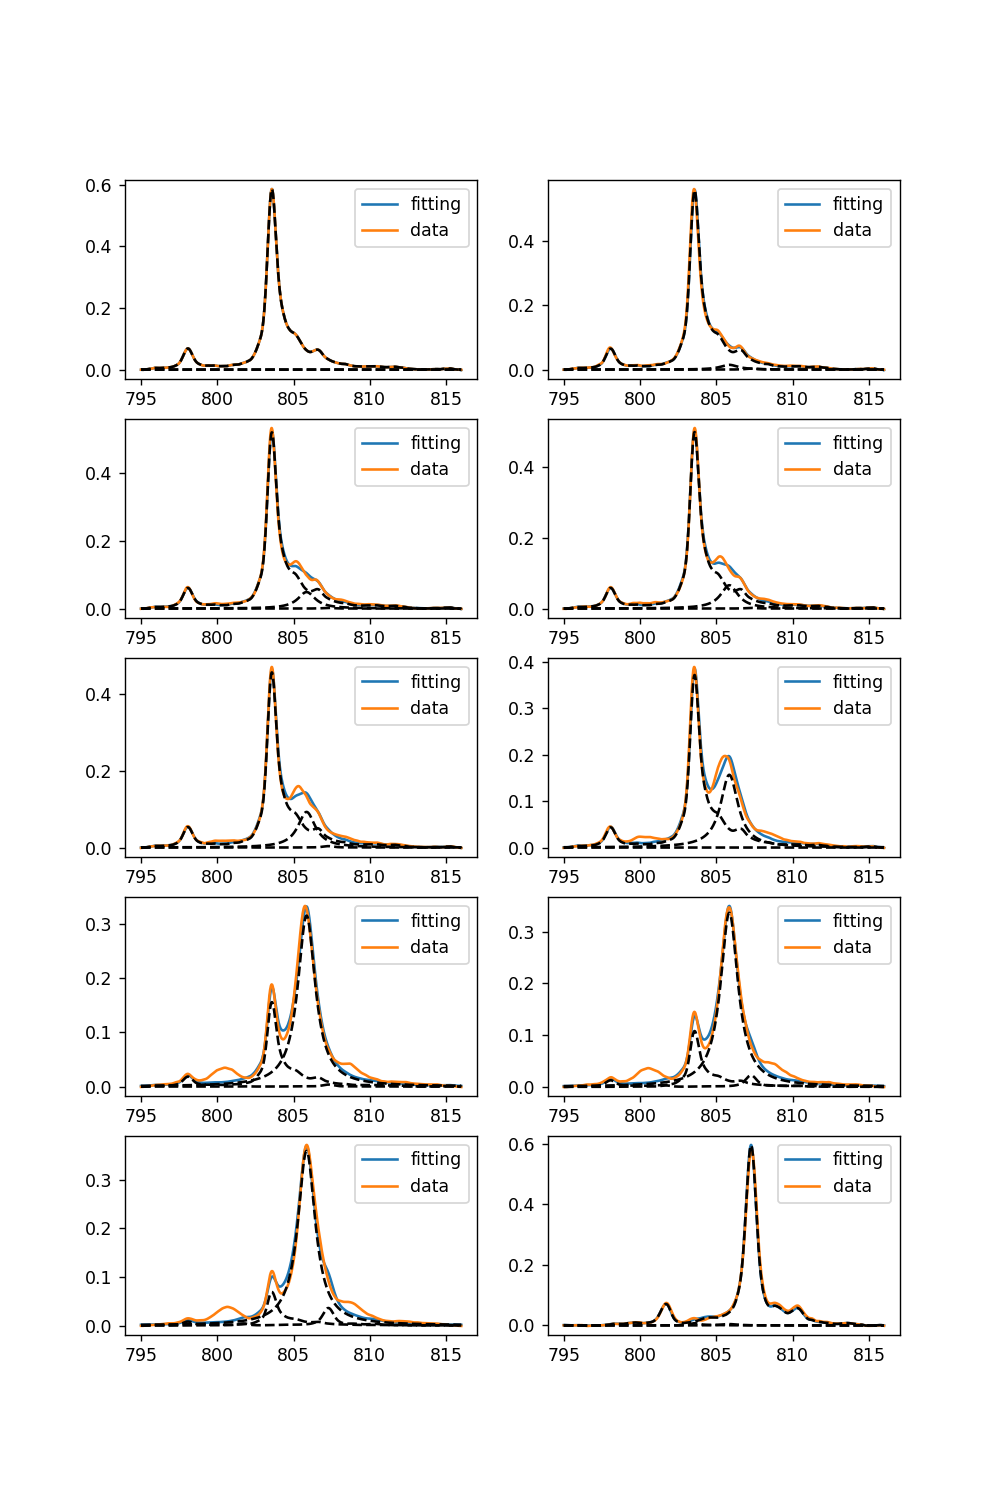

In [15]:
# Making a graph with subplots of all timepoints (10) containing the data and fitting
ans = pip.ans
Y = pip.ans.Y
A = pip.res.params['A']

fig, axes = plt.subplots(5, 2, figsize=(8, 12))
for i, ax in enumerate(axes.flatten()):
    a_s = A.T[i]
    ax.plot(x, Y.T[i], label='fitting')
    ax.plot(x, data_arr[i], label='data')
    ax.plot(x, a_s[0]*FD, color='k', linestyle='--')
    ax.plot(x, a_s[1]*native, color='k', linestyle='--')
    ax.plot(x, a_s[2]*ans.int1, color='k', linestyle='--')
    ax.legend()
plt.show()

<IPython.core.display.Javascript object>


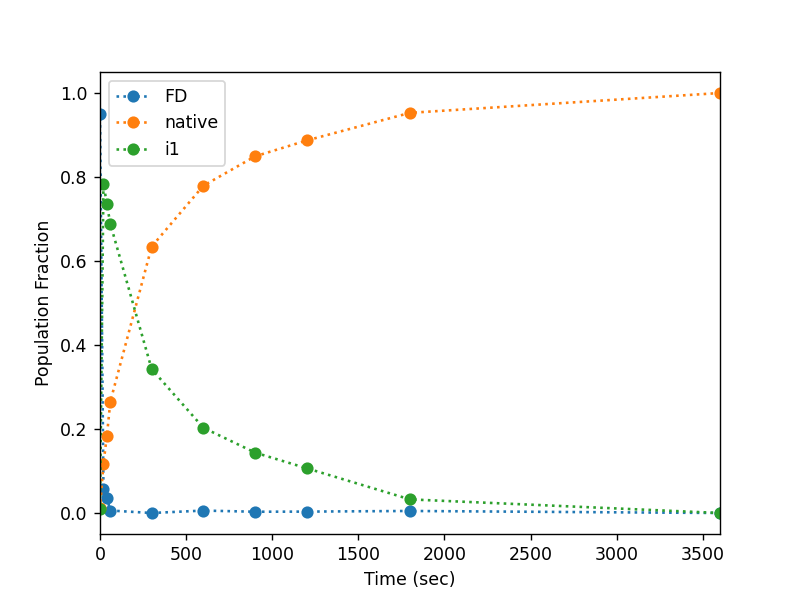

(0.0, 3600.0)

In [16]:
#Plotting the population fractions 
plt.figure()
labels = ['FD', 'native', 'i1']
for i, a in enumerate(A):
    plt.plot(time, a, label=labels[i], marker='o', linestyle=':')

plt.xlabel('Time (sec)')
plt.ylabel('Population Fraction')
plt.legend()
plt.xlim(0, 3600)

In [17]:
np.savetxt('Bwt_(AT1)_curve', A)